# Can bias be eliminated by adding a constant to the forecast?
### specifically, adding the difference between the last training data point and the prediction of the last training data point

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import norm, skewnorm, skew

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import *
from model_objs import *
import vanilla_benchmark

## Pinball Loss

In [4]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [5]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

## Vanilla Benchmark Forecast

In [6]:
pre_length = 12 * 365 * 24 // 12  # 12 months
min_train_start = 9 * 365 * 24 + 2 * 24 - pre_length # 2 leap years in from 2005 to 2014
train_starts = np.linspace(min_train_start, min_train_start + 24 * 365 - 24, 12, endpoint=False).astype(int)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [7]:
print(list(train_starts))

[70128, 70856, 71584, 72312, 73040, 73768, 74496, 75224, 75952, 76680, 77408, 78136]


In [8]:
zone_name = "ISONE CA"

In [9]:
# OLD vanilla_losses = [296.8847544483837, 430.00821029385423, 249.76186323507005, 228.45341573067495, 367.92242571414795, 359.81620926123105, 573.6220447228848, 663.6710716952123, 596.4665211942336, 211.61053854835038, 309.02862777154513, 430.58429049360274]

In [10]:
vanilla_losses = [397.54593426786477, 604.6018135096928, 329.1556644285198, 197.8631423987858, 323.53210964925717, 415.8909833353536, 544.7284618154562, 540.057213205938, 570.237691916539, 181.8698616921875, 262.12280478463936, 471.97246124553413]
# vanilla_losses = []
# for month in range(1, len(months) + 1):
#     print(months[month-1])
#     vanilla_losses.append(vanilla_benchmark.get_lossesGEFCom(10, 31 * 24, start_date=pd.Timestamp(f"2005-{month}-01"), zones=["ISONE CA"],
#                               delay_days=0, temp_years=np.arange(2005, 2015), plot=True)["ISONE CA"])

In [11]:
for i, loss in list(enumerate(vanilla_losses))[::2]:
    print(np.round(loss, 1), end="\t")

397.5	329.2	323.5	544.7	570.2	262.1	

In [12]:
import json

with open("GEFCom2017\\GEFCom2017-Qual\\GEFCom2017Qual2005-2015.json") as f:
    all_data = json.loads(f.read())
    
data = np.transpose(np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64))

In [13]:
# rescale data
x_original = data
mean = np.mean(data, axis=0)
rnge = np.max(data, axis=0) - np.min(data, axis=0)
data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
print("data", data.shape)

data (96408, 1)


# Forecasting mean, variance, and skewness of Skew-Normal distribution

In [14]:
%matplotlib inline
z_scores = []
test_z_scores = []
losses = []
relative_perfs = []

TRAIN START: 70128 = 2013-01-01 00:00:00
x (18264, 1)
xt (17520, 1)
Loss at iteration 10: -0.9823037793856391
Loss at iteration 60: -1.533215641186784
Loss at iteration 110: -1.7582677939121742
Loss at iteration 160: -1.8429185799638286
Loss at iteration 210: -1.8695523695068956
Loss at iteration 260: -1.8891112828773124
Loss at iteration 310: -1.9025132659266673
Loss at iteration 360: -1.915345486867622
Loss at iteration 410: -1.9271085120886764
Loss at iteration 460: -1.9359189801631613
Loss at iteration 510: -1.9453363248753937
Loss at iteration 560: -1.958767163539941
Final loss: -1.9615006888677273


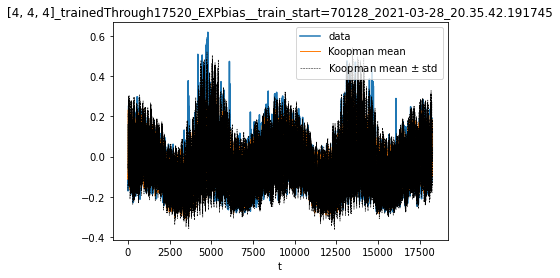

actual overall mean: 0  predicted mean: -0.0087532345


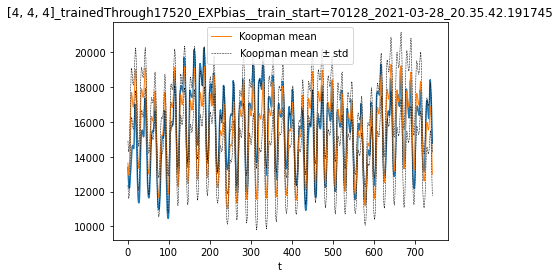

pinball_loss: 347.734434450833
12.52974701118914% performance relative to vanilla benchmark





TRAIN START: 71584 = 2013-03-02 00:00:00
x (18264, 1)
xt (17520, 1)
Loss at iteration 10: -1.0344617130232385
Loss at iteration 60: -1.4426602097175105
Loss at iteration 110: -1.750251279544717
Loss at iteration 160: -1.83842090140339
Loss at iteration 210: -1.8789775676000142
Loss at iteration 260: -1.9051437083065674
Loss at iteration 310: -1.9170451257530041
Loss at iteration 360: -1.926357741039489
Loss at iteration 410: -1.936482765473512
Loss at iteration 460: -1.9428054323822936
Loss at iteration 510: -1.9541987888586725
Loss at iteration 560: -1.9559601193571328
Final loss: -1.9563279941225933


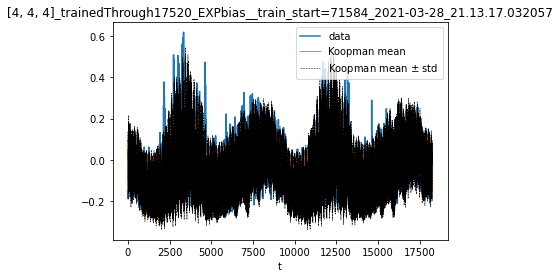

actual overall mean: 0  predicted mean: -0.0136701735


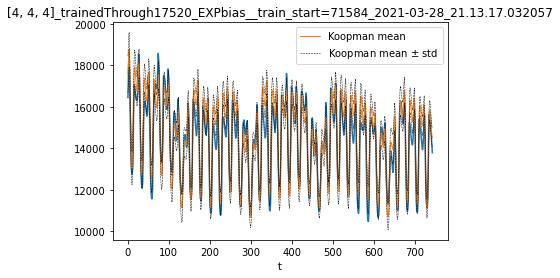

pinball_loss: 197.93299103273802
39.86644848528147% performance relative to vanilla benchmark





TRAIN START: 73040 = 2013-05-02 00:00:00
x (18264, 1)
xt (17520, 1)
Loss at iteration 10: -0.3362939561180057
Loss at iteration 60: -1.3326544535323286
Loss at iteration 110: -1.762188362849567
Loss at iteration 160: -1.8435988587540588
Loss at iteration 210: -1.8800829130492953
Loss at iteration 260: -1.9006912254576478
Loss at iteration 310: -1.9129223478453607
Loss at iteration 360: -1.9232068701386518
Loss at iteration 410: -1.9344548043298182
Loss at iteration 460: -1.939020718591332
Loss at iteration 510: -1.9464557454152254
Loss at iteration 560: -1.9506586530642624
Final loss: -1.9586443388759514


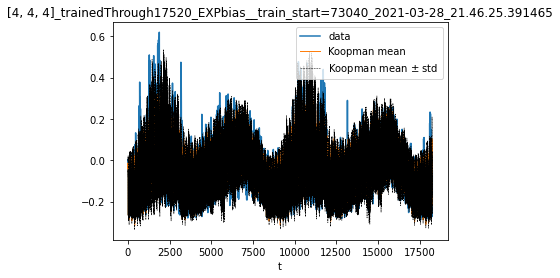

actual overall mean: 0  predicted mean: -0.0074739414


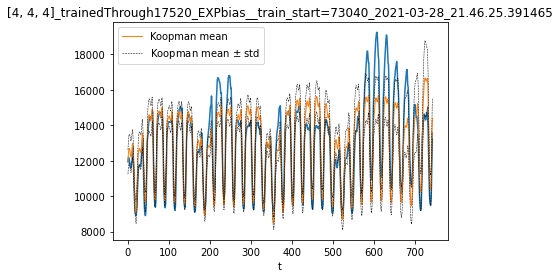

pinball_loss: 309.36864958039735
4.3777602427822355% performance relative to vanilla benchmark





TRAIN START: 74496 = 2013-07-02 00:00:00
x (18264, 1)
xt (17520, 1)
Loss at iteration 10: -0.5934112478242025
Loss at iteration 60: -1.3187302475737903
Loss at iteration 110: -1.6963605172207532
Loss at iteration 160: -1.7988929024198927
Loss at iteration 210: -1.8350626790670272
Loss at iteration 260: -1.8563846960019699
Loss at iteration 310: -1.8690375192172581
Loss at iteration 360: -1.8775159482723642
Loss at iteration 410: -1.8841001211419872
Loss at iteration 460: -1.89338351093668
Loss at iteration 510: -1.8961462067788308
Loss at iteration 560: -1.8980118266473929
Final loss: -1.9072613521755444


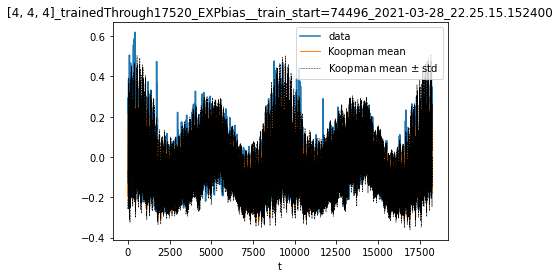

actual overall mean: 0  predicted mean: -0.013466588


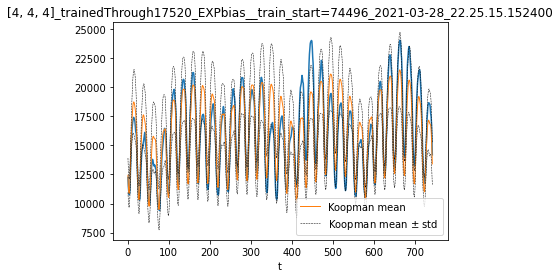

pinball_loss: 456.72440795730864
16.155582097702403% performance relative to vanilla benchmark





TRAIN START: 75952 = 2013-08-31 00:00:00
x (18264, 1)
xt (17520, 1)
Loss at iteration 10: -0.7531913226233617
Loss at iteration 60: -1.3605448816084578
Loss at iteration 110: -1.7013285454552667
Loss at iteration 160: -1.759204912935335
Loss at iteration 210: -1.7858956675751463
Loss at iteration 260: -1.8077411393035243
Loss at iteration 310: -1.8223797888847209
Loss at iteration 360: -1.83518176970975
Loss at iteration 410: -1.8535484432180807
Loss at iteration 460: -1.8706441950955122
Loss at iteration 510: -1.8859054541748783
Loss at iteration 560: -1.8948286096530427
Final loss: -1.8980196637847704


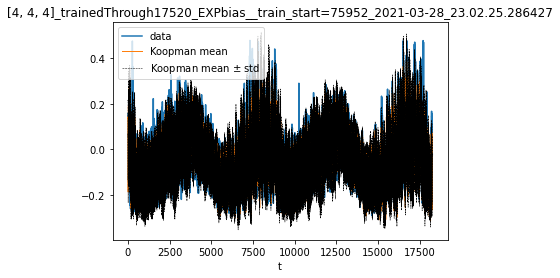

actual overall mean: 0  predicted mean: -0.011138436


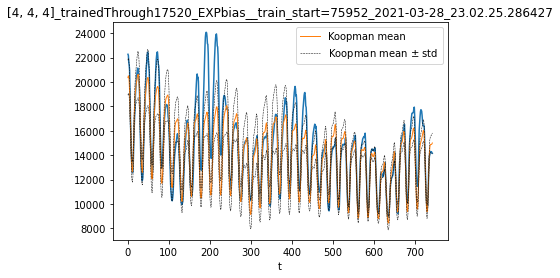

pinball_loss: 447.4306812001588
21.536108969512746% performance relative to vanilla benchmark





TRAIN START: 77408 = 2013-10-31 00:00:00
x (18264, 1)
xt (17520, 1)
Loss at iteration 10: -1.0136307252984569
Loss at iteration 60: -1.480194808817404
Loss at iteration 110: -1.7238573870806488
Loss at iteration 160: -1.7583043002369616
Loss at iteration 210: -1.7925487925781058
Loss at iteration 260: -1.8109986330794752
Loss at iteration 310: -1.8219653759549386
Loss at iteration 360: -1.8297652151414914
Loss at iteration 410: -1.8374342570901896
Loss at iteration 460: -1.842352584238883
Loss at iteration 510: -1.8486509004688507
Loss at iteration 560: -1.8574661565211155
Final loss: -1.8603675157136834


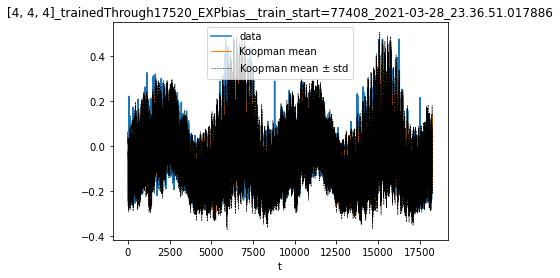

actual overall mean: 0  predicted mean: -0.011275851


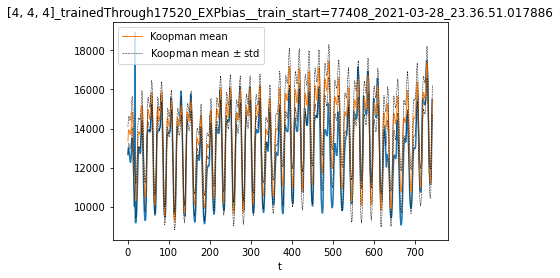

pinball_loss: 342.23794244448004
-30.563970855440626% performance relative to vanilla benchmark







In [15]:
for month, train_start in list(enumerate(train_starts))[::2]:
    print("TRAIN START:", train_start, "=", all_data[zone_name]["Date"][train_start])
    
    train_through = 365 * 24 + pre_length
    delay = 0  # 52 * 24
    predict_through = train_through + 24 * 31 + delay  
    x = data[train_start:]
    x = x[:predict_through]
    xt = x[:train_through]
    num_freqs = [4, 4, 4]
    num_fourier = 4
    mask = torch.ones(xt.shape, dtype=torch.uint8)
    mask[:pre_length] = 0
    loss_weights = 1 + 0.4 * torch.cos(torch.linspace(-2 * np.pi * pre_length / (xt.shape[0] - pre_length), 2 * np.pi, xt.shape[0]))
    print("x", x.shape)
    print("xt", xt.shape)
    
    now = ("_".join(str(datetime.now()).split())).replace(":", ".")
    data_name = "EXPbias_" + f"_train_start={train_start}_" + now

    ### TRAIN ###
    model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32, loss_weights=loss_weights)
    
    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.24])
    
    k.fit(xt, iterations=600, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=mask);

    fname = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}"
    mu_file = fname + "mu.npy"
    sigma_file = fname + "sigma.npy"
    alpha_file = fname + "alpha.npy"    

    ### FORECAST ###
    params = k.predict(predict_through)
    mu_hat, sigma_hat, a_hat = params
    # ADD TO CORRECT BIAS                                                    
#     adjust = np.mean((xt[pre_length:] - mean_hat[pre_length:train_through]) / std_hat[pre_length:train_through]) / (np.mean(1 / std_hat[pre_length:train_through]))
#     mu_hat += adjust                                                     # <<< CHANGE THIS LINE TO EXPERIMENT
    np.save(mu_file, mu_hat)
    np.save(sigma_file, sigma_hat)
    np.save(alpha_file, a_hat)

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    ### ANALYTICS ###
    print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

    z_scores.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])

    ### PERFORMANCE ###

    #Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    test_start = train_through + delay
    sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    delta = ah / (1 + ah ** 2) ** 0.5
    muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    sigh = sigh * rnge
    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)[0]
    relative = (1 - loss/vanilla_losses[month]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perfs.append(relative)

# Figures

In [16]:
# for tables
for loss in losses[:6]:
    print(np.round(loss, 1), end="\t")
print("")
for rel in relative_perfs[:6]:
    print(np.round(rel, 1), end="%\t")

347.7	197.9	309.4	456.7	447.4	342.2	
12.5%	39.9%	4.4%	16.2%	21.5%	-30.6%	

In [17]:
idx = 6
for z_score in z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")

-0.1	0.07	-0.01	0.06	-0.02	0.02	
0.96	0.98	0.99	0.98	0.98	0.98	
0.89	0.75	1.05	0.78	0.39	0.39	
-0.01	-0.44	0.07	0.03	0.59	-0.95	
0.92	1.0	1.4	0.75	1.24	1.0	
-0.25	-0.07	0.91	0.78	0.81	1.51	

In [18]:
z_scores = np.array(z_scores)
test_z_scores = np.array(test_z_scores)
losses = np.array(losses)
relative = np.array(relative_perfs)

In [19]:
np.save("experiments\\" + data_name + "z_scores.npy", z_scores)
np.save("experiments\\" + data_name + "test_z_scores.npy", test_z_scores)
np.save("experiments\\" + data_name + "relative_perfs.npy", relative_perfs)
np.save("experiments\\" + data_name + "losses.npy", losses)

In [208]:
import os
%matplotlib inline
z_scores = []
test_z_scores = []
losses = []
relative_perfs = []

TRAIN START: 84712 = 2014-08-31 00:00:00
x (9504, 1)
xt (8760, 1)
EXPepochs__train_start=84712_2021-03-24_00.53.01.507331trained84712-8760_[4, 4, 4]alpha.npy
EXPepochs__train_start=84712_2021-03-24_00.53.01.507331trained84712-8760_[4, 4, 4]mu.npy
EXPepochs__train_start=84712_2021-03-24_00.53.01.507331trained84712-8760_[4, 4, 4]sigma.npy


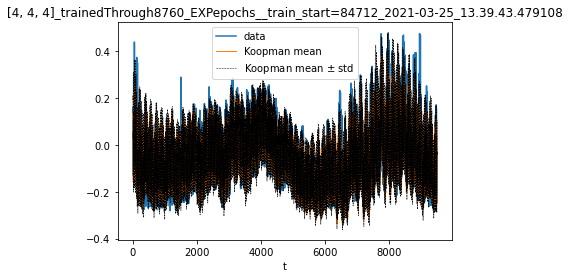

predicted mean: -0.013006175  actual: -0.012378204485746567
bias train: 7.272471678543838e-09 bias test: 0.42876440084031203


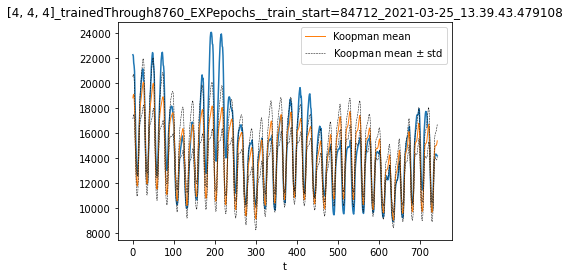

pinball_loss: 492.95214429498424
13.553216267027546% performance relative to vanilla benchmark







In [210]:
path = "C:\\Users\\ATMal\\PycharmProjects\\koopman-forecasting\\forecasts\\experiment10"
for month, train_start in list(enumerate(train_starts))[::2][4:5]:
    print("TRAIN START:", train_start, "=", all_data[zone_name]["Date"][train_start])
    
    train_through = 365 * 24
    delay = 0  # 52 * 24
    predict_through = train_through + 24 * 31 + delay  
    x = data[train_start:]
    x = x[:predict_through]
    xt = x[:train_through]
    num_freqs = [4, 4, 4]
    num_fourier = 4
    loss_weights = 1 + 0.4 * torch.cos(torch.linspace(0, 2 * np.pi, xt.shape[0]))
    print("x", x.shape)
    print("xt", xt.shape)
    
    now = ("_".join(str(datetime.now()).split())).replace(":", ".")
    data_name = "EXPepochs_" + f"_train_start={train_start}_" + now

    ### TRAIN ###
    model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
    
    ### GET OLD DATA
    for fname in os.listdir(path):
        if fname.startswith(f"EXPepochs__train_start={train_start}"):
            print(fname)
            if fname.endswith("alpha.npy"):
                a_hat = np.load(os.path.join(path, fname))
            if fname.endswith("sigma.npy"):
                sigma_hat = np.load(os.path.join(path, fname))
            if fname.endswith("mu.npy"):
                mu_hat = np.load(os.path.join(path, fname))
    params = (mu_hat, sigma_hat, a_hat)
    
    fname = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}"
    mu_file = fname + "mu.npy"
    sigma_file = fname + "sigma.npy"
    alpha_file = fname + "alpha.npy"
    
    mean_hat = model.mean(params)
    std_hat = model.std(params)
    
    adjust = np.mean((xt - mean_hat[:train_through]) / std_hat[:train_through]) / (np.mean(1 / std_hat[:train_through]))
    mu_hat += adjust                                                     # <<< CHANGE THIS LINE TO EXPERIMENT
#     mu_hat += xt[-1] - mean_hat[train_through - 1]
    np.save(mu_file, mu_hat)
    np.save(sigma_file, sigma_hat)
    np.save(alpha_file, a_hat)

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    ### ANALYTICS ###
    print("predicted mean:", np.mean(mean_hat[:train_through]), " actual:", np.mean(xt))

    z_scores.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])
    print("bias train:", np.mean(z_scores[-1]), "bias test:", np.mean(test_z_scores[-1]))

    ### PERFORMANCE ###

    #Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    test_start = train_through + delay
    sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    delta = ah / (1 + ah ** 2) ** 0.5
    muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    sigh = sigh * rnge
    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)[0]
    relative = (1 - loss/vanilla_losses[month]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perfs.append(relative)

Text(0, 0.5, 'standardized residual $z$')

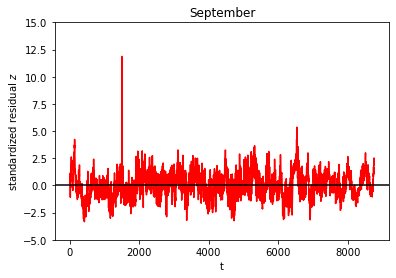

In [211]:
plt.plot(z_scores[4], color="r")
plt.title("September")
plt.axhline(0, color="k")
plt.xlabel("t")
plt.ylim([-5, 15])
plt.ylabel("standardized residual $z$")

In [96]:
zs = (xt - mu_hat[:train_through]) / sigma_hat[:train_through]

In [97]:
b = np.mean(zs)

In [98]:
a = b / (np.mean(1 / sigma_hat[:train_through]))

In [99]:
a

0.03618646150443811

In [100]:
zsc = (xt - (mu_hat[:train_through] + a)) / sigma_hat[:train_through]

In [101]:
zsc.mean()

1.130180568147571e-07